In [11]:
import random
import math
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy
import matplotlib.pyplot as plt
from itertools import combinations # product: 排列

"""
## import function

- Parsing_midi
    - get_midi
    - get_pitch
    - parse_midi
    - separate_phrase

- Init_chromo
    - shift_note
    - merge_duplicate_note
    - extend_duration
"""
print()

### Output to midi file

In [12]:
def to_midi_file(inputfile, program, outputfile):
    ## initialize
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ## add message
    track.append(Message('program_change', program=program, time=0))
    for i in range(len(inputfile)):
        track.append(Message('note_on', note=inputfile[i].note, velocity=inputfile[i].velocity, time=inputfile[i].time))
    mid.save(outputfile)
    return True

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)
- Parameters:
    - base
    - midi list
    - threshold

In [13]:
midi_list = pm.get_midi('MidiSample/sky.mid', 0)

In [14]:
def trans_note_list(song):
    return [song[i].note for i in range(len(song))]

note_msg, midi_msg = pm.separate_song(midi_list, 15360)
parent = midi_msg[0]  # change here for testing

def flatten_list(midi_list):
    return [item for sublist in midi_list for item in sublist]

In [15]:
## transform to C major #-3
for i in range(len(parent)):
    parent[i].note = parent[i].note -3 # shift
[parent[i].note - 9 for i in range(len(parent))]
    
to_midi_file(parent, 1 , 'ori.mid')

True

In [16]:
## original
note_msg, midi_msg = pm.separate_song(parent, 1920)
origin_note = [trans_note_list(midi_msg[i]) for i in range(len(midi_msg))]
(origin_note)

[[69, 69, 71, 71],
 [72, 72, 71, 71, 72, 72, 76, 76],
 [71, 71, 64, 64],
 [69, 69, 67, 67, 69, 69, 72, 72],
 [67, 67, 64, 64, 64, 64],
 [65, 65, 64, 64, 65, 65, 72, 72],
 [64, 64, 72, 72, 72, 72, 72, 72],
 [71, 71, 66, 66, 71, 71]]

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [17]:
pitch_ary = [[0,1,0],[-1,0,7],[0,-1,2],[1,0,9],[0,1,4],[-1,0,11],[0,-1,6], [1,0,1], [0,1,8],[-1,0,3],[0,-1,10],[1,0,5]]

## Get CE 
def count_unique(ary):
    u = []
    unique = [i for i in ary if i not in u]
    return unique, len(unique)

def count_CE(notes_seq):
    note_seq1, Dab = count_unique(notes_seq)
    sum_dp = 0
    for pij in note_seq1:
        dij = 1  # duration
        sum_dp += np.array(dij * pij)  
    CE = sum_dp/Dab
    return CE

# transform to coordinate
def trans_to_coordinate(seq):
    ary = []
    for i in range(len(seq)):
        if i % 2 == 0:
            pitch_ary[(seq[i].note) % 12][2] = seq[i].note
            ary.append(pitch_ary[(seq[i].note) % 12])
    return ary

# get original CE
def get_ce_list(midi_msg):
    xyz = [trans_to_coordinate(midi_msg[i]) for i in range(len(midi_msg))]    
    CE = [count_CE(xyz[i]) for i in range(len(xyz))]
    return CE

CE = get_ce_list(midi_msg)

def count_distance(ori, new):
    return round(np.sqrt(sum(np.array(ori - new) ** 2)), 2) 

In [18]:
## Selection
def get_fitness_score(midi_msg):
    score = 0
    for i in range(len(CE)): # 分小節計算分數
        ## 轉換encoding
        temp = copy.deepcopy(midi_msg)
        note = trans_note_list(temp[i])
        ## 計算fitness
        _score, mid = fitness(temp[i], note, CE[i], origin_note[i]) # 一小節之分數
        score += _score
    return score

def select_best(pop_list):
    pop_idx = [i for i in range(len(pop_list))]
    score = -1000; pop1 = []; pop2 = []
    candidate = list(combinations(pop_idx, 2))
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        ind_note1, ind_midi1 = pm.separate_song(individual1, 1920) 
        ind_note2, ind_midi2 = pm.separate_song(individual2, 1920) 

        score1 = get_fitness_score(ind_midi1)  # 多個小節
        score2 = get_fitness_score(ind_midi2)

        total_score = score1 + score2
        if score < total_score :
            score = total_score
            pop1, pop2 = ind_midi1, ind_midi2
    return pop1, pop2, score

## Crossover
def crossover(parent, pop):
    ind1 = copy.deepcopy(parent)
    ind2 = copy.deepcopy(pop)
    crossover_point = random.randint(0,len(ind1))
    while crossover_point % 2 != 0 :
        crossover_point = random.randint(0,len(ind1))
    pop_midi1 = ind1[ :crossover_point] + ind2[crossover_point: ]
    pop_midi2 = ind2[ :crossover_point] + ind1[crossover_point: ]
    return pop_midi1, pop_midi2
    
## Mutation
def mutation(child): 
    temp = copy.deepcopy(child)
    mute_point = random.randint(0,len(temp)-1)  #選擇一點做突變
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(temp)-1)
    mutate_note = init.get_note(temp[mute_point].note)
    if temp[mute_point].note + mutate_note > 50 and temp[mute_point].note + mutate_note < 90:
        temp[mute_point].note = temp[mute_point].note + mutate_note
        temp[mute_point + 1].note = temp[mute_point].note
    return temp

In [19]:
## Evaluation

## base on CE get the chord name 
C_pitch = [0, -1, 2, -1, 4, 5, -1, 7, -1, 9, -1, 11]
chord_list = [[0,4,7],[-1,-1,-1],[2,5,9],[-1,-1,-1],[4,7,11],[5,9,0],[-1,-1,-1],[7,11,2],[-1,-1,-1],[9,0,4],[-1,-1,-1],[11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord, ori_note): # type: list
    score = 0
    scale_list = [0,2,4,5,7,9,11]
    
    ## 看整個小節的調性變化
    xyz_ = trans_to_coordinate(midi_msg)
    CE_ = count_CE(xyz_)
    dist = count_distance(chord, CE_)
    if dist == 0.0:
        score += 6
    elif dist > 0 and dist <= 2:
        score += 4
    elif dist > 3 and dist <= 4:
        score += 3
    elif dist > 4:
        score -= 10
    if len(midi_msg) != len(ori_note):
        score += 5
    
    ## get chord note
    c = int(list(chord)[2])
    if c % 12 in C_pitch:
        chord = chord_list[c % 12]
    elif c + 1 % 12 in C_pitch:
        chord = chord_list[c + 1 % 12]
    elif c - 1 % 12 in C_pitch:
        chord = chord_list[c - 1 % 12]
    
    ## 計算單一PITCH
    for i in range(len(midi_msg)):
        if i % 2 == 0:
            if midi_msg[i].note in ori_note: # keep original melody
                score += 5
            elif midi_msg[i].note not in ori_note:
                score -= 1
                
#             if abs(midi_msg[i].note - midi_msg[i+2].note) == 4: ## major third -- to do
#                 score += 4
#             if abs(midi_msg[i].note - midi_msg[i+2].note) == 7: ## perfect fifth -- to do
#                 score += 4
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) >= 7:  ## big jump note
                score = score - 10 
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) == 0: 
                score = score - 5                
            if midi_msg[i].note % 12 == chord[0]:## chord root note
                score += 4
            if midi_msg[i].note % 12 == chord[1]:## 2nd note
                score += 3
            if midi_msg[i].note % 12 == chord[2]:## 3rd note
                score += 3               
            if midi_msg[i].time - midi_msg[i+1].time < 65: ## 裝飾音
                score += 4                
            if i == 0 and midi_msg[i].note % 12 == chord[0]:  # first note
                score += 3
            if i == 0 and midi_msg[i].note % 12 == chord[1]:
                score += 2
            if i == 0 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3   
                
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[0]:  # last note
                score += 3
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[1]:
                score += 2
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3
                
            if midi_msg[i].note % 12 not in chord: # note is not a chord note
                score -= 2
            if midi_msg[i].note % 12 not in scale_list:  # note not in the scale
                score -= 10
            
    return score, midi_msg

### Main Function
- initialize 有六種組合
- 挑分數最高的兩條做crossover, mutation 產生300種不同組合
- 從這300條中挑選分數最高的兩條繼續演化

In [ ]:
%%time
## MAIN
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.4
GENERATIONS = 200
count = 0; score_list = []; midi_list = []; score_list = []; temp = []

## Initialize 
# 增加裝飾音
pop1 = init.add_note(parent, 119, 1)
pop2 = init.add_note(parent, 239, 1)
pop3 = init.add_note(parent, 119, 1)
pop4 = init.add_note(parent, 239, 1)
pop5 = init.add_note(parent, 119, 1)  
pop6 = init.add_note(parent, 59, 1)
pop7 = init.add_note(parent, 119, 1)
pop8 = init.add_note(parent, 59, 1)
pop9 = init.add_note(parent, 119, 2)
pop10 = init.add_note(parent, 59, 1)
pop11 = init.add_note(parent, 119,2) 
pop12 = init.add_note(parent, 119, 1) 
pop13 = parent                                    # origin       
pop14 = init.merge_duplicate_note(parent)         # 重複的切分音直接轉為連音
pop15 = init.change_duration(parent, 120, 480, 3) # 延長音 16分音符->一拍
pop16 = init.change_duration(parent, 240, 120, 3) # 縮短音 16分音符->8分音符
pop17 = init.remove_note(parent, 300)             # 移除音符

pop_list = [pop1, pop2, pop3, pop4, pop5, pop6, pop7, pop8, pop9, pop10, pop11, pop12, pop13, pop14, pop15, pop16, pop17]

# choose 2 best candidate
pop1, pop2, scr1 = select_best(pop_list)

# flattern 
parent = flatten_list(pop1)
pop = flatten_list(pop2)

score_list.append(scr1)


while count < GENERATIONS:
    candidate_list = []
  
    # crossover, mutation * N times
    for i in range(60):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:  
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        else:
#             mutation_c1 = crossover_c1
#             mutation_c2 = crossover_c2
            mutation_c1 = init.add_note(crossover_c1, 119, 1)
            mutation_c2 = init.add_note(crossover_c2, 239, 1)
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
        
    # select best 2 from 300 populations   
    parent, pop, scr2 = select_best(candidate_list)

    parent = flatten_list(parent)
    pop = flatten_list(pop)

    # 先儲存一個
    to_midi_file(parent, 1 , 'Output_midi/sky_output1_' + str(scr2) + "_" + str(count) + '.mid')
    to_midi_file(pop, 1 , 'Output_midi/sky_output2_' + str(scr2) + "_" + str(count) + '.mid')

    score_list.append(scr2)
        
    count += 1
    print("score", scr2)
    
print("Finish")

score 458
score 489
score 513
score 527
score 554
score 585
score 600
score 616
score 630
score 643
score 653
score 666
score 669
score 671
score 674
score 674
score 682
score 682
score 682
score 685
score 688
score 688
score 688
score 688
score 688
score 688


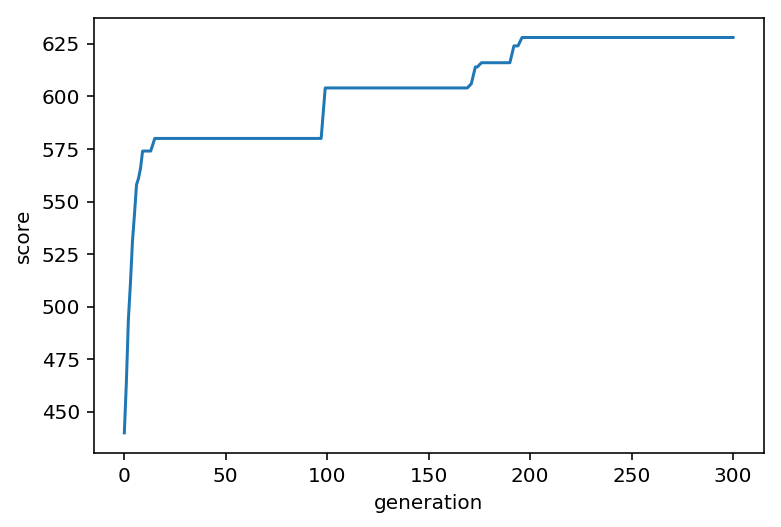

In [11]:
plt.plot(score_list)
plt.xlabel('generation')
plt.ylabel('score')
plt.show()